In [57]:
import pyomo.environ as pyo
import numpy_financial as npf
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from summSD import summary
import time
startTime=time.time()

#selfDispatchOptimization，8760运行 2h10min后有解, 2880小时 7min后有解，200小时 数秒钟有解
#将8760分解为4部分后求解速度可以大幅度提升，依旧是全小时，但是每个问题的尺寸变小，计算时间成倍减少。

Tech=['Coal', 'LNG', 'Wind', 'PV']

Age=['New', 'Mid', 'Old']

Thermal=['Coal', 'LNG']

VRE=['Wind', 'PV']


# H,pmaxDic,demandData,priceData,carbonPrice 作为输入

H = 672   #8760   #2880     #672
years=30

pmaxDic={} #后指 workingcapacity

df=pd.read_excel('techPara_real.xlsx',sheet_name='pmax_table',index_col=0)
Dic=df.to_dict()
for k in Tech:
    for p in Age:
        pmaxDic[k,p]=Dic[p][k] #行列互换了一下以匹配pyomo
#pmaxDic[k,p]=float(''.join(str(i) for i in pmaxDic[k,p]))因为输入miss。在上一行代码后面多打了一个逗号‘，’导致生成的值变成了元组。使用这行代码将元组转换为字符串再转换为数值。


#需求
df_demand= pd.read_excel('hourlyData2019.xlsx',sheet_name='2019DemandTrial',header=None,nrows = H)
demandData = df_demand .to_numpy().flatten()
demandIncrease=0.3  #30% increase until 2050. 30%-50%.
#newDemand=[round((demandIncrease*i/years)*(year-2019)+i,0) for i in demandData ]



#电价
df_price= pd.read_excel('hourlyData2019.xlsx',sheet_name='2019HistoricalPriceTrial',header=None,nrows = H)
priceData = df_price.to_numpy().flatten()
hourlyPriceOpt=[]

#VRE出力因子
df_Wind=pd.read_excel('hourlyData2019.xlsx',sheet_name='2019WindTrial',header=None,nrows = H)
WindNewCapacityFactor=df_Wind.to_numpy().flatten()

df_PV=pd.read_excel('hourlyData2019.xlsx',sheet_name='2019SolarTrial',header=None,nrows = H)
PVNewCapacityFactor=df_PV.to_numpy().flatten()

    
#碳价
carbonSwitch=1
CO2FloorPrice=50
carbonPrice=CO2FloorPrice

#容量价格
#capacityBasePrice=89942.86
capacityBasePrice=89942.86
capacitySwitchCoal=0
capacitySwitchLNG=1

mothDic={}
retireDic={}
allCapacityDic={}

for i in Tech:
    for j in Age:
        exec ("capacityChange{}{}=[]".format(i,j))
        exec ("workingChange{}{}=[]".format(i,j))
        exec ("mothballChange{}{}=[]".format(i,j))
        exec ("retireChange{}{}=[]".format(i,j))
        exec ("Generation{}{}=[]".format(i,j))
        exec ("Curtail{}{}=[]".format(i,j))

allElecPrice=[]        
allCO2=[]
allDemand=[]
allImport=[]
allReject=[]
allCO2Price=[]
allCapacityPrice=[]

print("all Capacity:\n",allCapacityDic,"\nworking Capacity:\n",pmaxDic,"\nmothball:\n",mothDic,"\nretire Capacity:\n",retireDic)
print("\nAll Capacity:",sum(allCapacityDic.values()),"      Available Supply:",sum(pmaxDic.values()),"       MaxDemand:",max(demandData),"\n")

totalEmissionOpt,newInvestCoalOpt,newInvestLNGOpt,newInvestWindOpt,newInvestPVOpt,\
cashflowCoalNewOpt,cashflowCoalMidOpt,cashflowCoalOldOpt,\
cashflowLNGNewOpt,cashflowLNGMidOpt,cashflowLNGOldOpt,\
cashflowWindNewOpt,cashflowWindMidOpt,cashflowWindOldOpt,\
cashflowPVNewOpt,cashflowPVMidOpt,cashflowPVOldOpt,\
hourlyPriceOpt,importElecOpt,capacityPriceOpt,\
CoalNewOutputOpt,CoalMidOutputOpt,CoalOldOutputOpt,\
LNGNewOutputOpt,LNGMidOutputOpt,LNGOldOutputOpt,\
WindNewOutputOpt,WindMidOutputOpt,WindOldOutputOpt,\
PVNewOutputOpt,PVMidOutputOpt,PVOldOutputOpt,\
WindNewCurtail,WindMidCurtail,WindOldCurtail,\
PVNewCurtail,PVMidCurtail,PVOldCurtail=summary(H,pmaxDic,demandData,WindNewCapacityFactor,PVNewCapacityFactor,carbonPrice,carbonSwitch,capacitySwitchCoal,capacitySwitchLNG,capacityBasePrice)
#从优化来的返回值

emissionStart=totalEmissionOpt



all Capacity:
 {} 
working Capacity:
 {('Coal', 'New'): 966.0, ('Coal', 'Mid'): 1078.67, ('Coal', 'Old'): 616.5, ('LNG', 'New'): 647.4, ('LNG', 'Mid'): 700.0, ('LNG', 'Old'): 1098.0, ('Wind', 'New'): 459.05, ('Wind', 'Mid'): 0.0, ('Wind', 'Old'): 0.0, ('PV', 'New'): 1327.2797, ('PV', 'Mid'): 0.0, ('PV', 'Old'): 0.0} 
mothball:
 {} 
retire Capacity:
 {}

All Capacity: 0       Available Supply: 6892.8997        MaxDemand: 5422 

Not sufficient flexibility(Import but Not ElecPriceCap) 0 Times
Not sufficient capacity(Import & ElecPriceCap) 5 Times
Not enough reserve capacity: 794.04 MW
Current Year Capacity Price: 133849.56 $/MW
cashflowCoalNew: -73735.84441820439
cashflowCoalMid: -236006.57329834005
cashflowCoalOld: -418058.7401584716
cashflowLNGNew: 168924.94607761997
cashflowLNGMid: 144158.51935195344
cashflowLNGOld: 129108.81263895668
cashflowWindNew: 553804.9357109144
cashflowWindMid: 0
cashflowWindOld: 0
cashflowPVNew: 241921.09913905038
cashflowPVMid: 0
cashflowPVOld: 0
cashflowCoal

In [58]:
#目前只需读取一次模型所以暂时不用将SD打包
#未来如果希望改变运行年数，使用for循环反复运行，可能还需要打包

from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import BPTK_Py
import json






#从时间0开始计算
start=0
steps=years#模型期间,即使改变dt也无需改变期间，dt变的只是期间内的间隔。

model = Model(starttime=start,stoptime=steps,dt=0.25,name='SDOnly') 
#二进制计算，所以尽量将时间间隔设定为以2为底的幂乘,4,2,1,0.5,0.25,0.125，否则会增大误差
#如果不得不设定其他数字的dt，多保留小数位数，或者可以尝试改变整个模型的时间单位，例如从年改为月，从而减少截断误差

#****************************************************************************************

#CFWind=0.266963886
#CFSolar=0.159827451   

#             New      Mid     Old
# Coal   966.0000  1078.67   616.5
# LNG    647.4000   700.00  1098.0
# PV    1327.2797     0.00     0.0
# Wind   459.0500     0.00     0.0

techSD=['Coal', 'LNG', 'Wind', 'PV']
thermalSD=['Coal', 'LNG'] 
vreSD=['Wind', 'PV']
ageSD=['New', 'Mid', 'Old']


pmaxDic={}
df=pd.read_excel('techPara_real.xlsx',sheet_name='pmax_table',index_col=0)
Dic=df.to_dict()
for k in techSD:
    for p in ageSD:
        pmaxDic[k,p]=Dic[p][k]#行列互换了一下以匹配pyomo
        
#*********************************  读取数据命名变量 *******************************************************

emissionReceiver = model.converter("emissionReceiver")
emissionReceiver.equation = 18340725.41
#使用格式化函数命名变量
for i in techSD:
    for j in ageSD:
        exec ("capacity{}{}=model.stock(\"capacity{}{}\")".format(i,j,i,j))

        
        exec ("newInvest{}=model.flow(\"newInvest{}\")".format(i,i))        
        exec ("retire{}{}=model.flow(\"retire{}{}\")".format(i,j,i,j))
        exec ("aging{}{}=model.flow(\"aging{}{}\")".format(i,j,i,j))
        exec ("initial{}{}Aging=model.flow(\"initial{}{}Aging\")".format(i,j,i,j))
        
        #接收来自opt的数据，cashflow本身是converter，无需再次建立
        exec ("newInvest{}Receiver = model.converter(\"newInvest{}Receiver\")".format(i,i))
        exec ("newInvest{}Receiver.equation = 0.0".format(i))

        exec ("initial{}{}Capacity= model.converter(\"initial{}{}Capacity\")".format(i,j,i,j))
        exec ("initial{}{}Retire= model.converter(\"initial{}{}Retire\")".format(i,j,i,j))
        #exec ("unitMaintenance{}{}=model.converter(\"unitMaintenance{}{}\")".format(i,j,i,j))
        
        exec ("capacity{}{}.initial_value=pmaxDic[i,j]".format(i,j))
        exec ("initial{}{}Capacity.equation = pmaxDic[i,j]".format(i,j))
        #临时假设前20年每年100投资
        #exec ("newInvest{}.equation = sd.If( sd.time()<20, 200,0 )".format(i))
        
        #从优化结果接受年度新投资
        exec ("newInvest{}.equation = newInvest{}Receiver".format(i,i))
        #exec ("newInvest{}.equation = sd.If( sd.time()<1,newInvest{}Opt,0 )".format(i,i))
      
        #退役量要和当前量或者aging量挂钩，否则会导致容量为负。因为aging在持续流出，如果提前退役，那么aging量也应该减少。
        #并且，因为固定投资下，New和Mid最终都会变为 0， 所以如果有提前退役，那么其最终总量必然为负。
        #最简单的处理方法是规定只有进入Old的机组才会退休。
        #另一个处理方法是，优先退休，让aging量小于存量减去退休量，并且规定老化量不能超过现有存量。退休量也不能超过现有存量.       
        #exec ("retire{}{}.equation = sd.min(sd.random(0.0, 200.0),capacity{}{})".format(i,j,i,j))
        
        
        #当年度cashflow  
        exec ("cashflow{}{}=model.converter(\"cashflow{}{}\")".format(i,j,i,j))
        #临时假设随机cashflow
        #exec ("cashflow{}{}.equation = sd.random(-10.0, 10.0)".format(i,j))
        
        #从优化结果读取cashflow
        #exec ("cashflow{}{}.equation = 0.0".format(i,j))
        #exec ("cashflow{}{}.equation = sd.If( sd.time()<1, cashflow{}{}Opt,0 )".format(i,j,i,j))


        
        
#*********************************  Carbon price *******************************************************
emissionCap = model.converter("emissionCap")
CO2Price = model.converter("CO2Price")
emissionRatio = model.converter("emissionRatio")

#只要参数不随着时间变化而变化，就可以在SD之外定义，不需要使用converter
CO2FloorPriceSD = model.converter("CO2FloorPriceSD")
sensiCoeCarbon = model.converter("sensiCoeCarbon")
CO2FloorPriceSD.equation=CO2FloorPrice #80.0    30
sensiCoeCarbon.equation=1.0 #carbon price els
#CO2FloorPrice=carbonPrice #80.0    30
#sensiCoeCarbon=1.0 #carbon price els

#cap计算，线性递减
#emissionStart=  #起始点，2019yearly emission:18340725.41
allowance=[emissionStart,]
allowance=[round((-emissionStart/years)*i+emissionStart,2) for i in range(0,years+1) ]
allowance.pop() #将最后一个0.0弹出
allowance.append(0.01) #用0.01替换弹出的0.0以避免除以零
allowancesList = list(map(list,zip([i for i in range(0,years)],allowance)))#将年数和排放额度绑定
model.points["allowances"] = allowancesList #将列表写入表函数       

# print(allowancesList)
# model.plot_lookup("allowances")
emissionCap.equation = sd.lookup(sd.time(),"allowances") 

#接受优化结果

emissionRatio.equation = emissionReceiver/emissionCap

CO2Price.equation = sd.round( sd.min(sd.If(emissionRatio>1,CO2FloorPriceSD*emissionRatio*sensiCoeCarbon,CO2FloorPriceSD),1000.00),2)
#CO2Price.equation = sd.If(emissionRatio>1,CO2FloorPrice*emissionRatio*sensiCoeCarbon,CO2FloorPrice)
        
         
        
        
#********************************* Retire and mothball *******************************************************


#原capacity作为全capacity，与opt互动的working capacity，等于capacity- mothball。

     
for i in thermalSD:
    for j in ageSD:
        
        #封存量
        exec ("mothball{}{}=model.stock(\"mothball{}{}\")".format(i,j,i,j))
        exec ("mothball{}{}.initial_value=0.0".format(i,j))
        exec ("working{}{}=model.converter(\"working{}{}\")".format(i,j,i,j))
        exec ("working{}{}.equation = sd.max(capacity{}{}-mothball{}{},0)".format(i,j,i,j,i,j))   
            
        exec ("cashCount{}{}=model.stock(\"cashCounter{}{}\")".format(i,j,i,j))
        exec ("cashCount{}{}.initial_value=0.0".format(i,j))
        exec ("cashCountIn{}{}=model.flow(\"cashCounterIn{}{}\")".format(i,j,i,j))
        exec ("cashCountIn{}{}.equation = sd.If(cashflow{}{}>0,0,1)".format(i,j,i,j))
        exec ("cashCountClean{}{}=model.flow(\"cashCounterClean{}{}\")".format(i,j,i,j))
        exec ("cashCountClean{}{}.equation = sd.If(cashflow{}{}>0,cashCount{}{},0)".format(i,j,i,j,i,j))
        exec ("cashCount{}{}.equation = cashCountIn{}{} - cashCountClean{}{}".format(i,j,i,j,i,j))
        
        #若cashflow小于0，则封存500MW,或封存20%
        exec ("suspend{}{}=model.flow(\"suspend{}{}\")".format(i,j,i,j))
        exec ("suspend{}{}.equation = sd.If(cashflow{}{}>0,0,working{}{}*0.2)".format(i,j,i,j,i,j))
        exec ("reins{}{}=model.flow(\"reins{}{}\")".format(i,j,i,j))
        exec ("reins{}{}.equation = sd.If(sd.And(cashflow{}{}>0 ,mothball{}{}>0),mothball{}{},0)".format(i,j,i,j,i,j,i,j))
        
        exec ("retire{}{}.equation = sd.max(sd.min( sd.If(sd.And(cashCount{}{}>=2 ,cashflow{}{}<=0),mothball{}{},0),mothball{}{}),0.0)".format(i,j,i,j,i,j,i,j,i,j))
        exec ("mothball{}{}.equation = suspend{}{} - reins{}{}-retire{}{}".format(i,j,i,j,i,j,i,j))
#如何确保在最后一个负收入时刻新加入的部分不退役
#由于流入存量自带一个时间步的延迟，同时等待时间为2年，所以退役时刚好错开了最后一个时刻加入的流量（因为退役的是当前stock量，而最后一个时刻的流量要在下一个时刻才能加入stock量）

      

#*********************************  Aging Chain *******************************************************

#40,40,20,20
#0-20,20-40,40+
#0-10,10-15,15-20
for i in thermalSD:
    for j in ageSD:
        exec ("initial{}{}Retire.equation = initial{}{}Capacity/20".format(i,j,i,j))
        #初始New量20年内老化。#初始状态下的New线性速度老化(与当前NewCapacity量无关)，共20年全部变成Mid
        exec ("initial{}{}Aging.equation = sd.If( sd.time()<20, initial{}{}Retire,0 )".format(i,j,i,j))
for i in vreSD:
    for j in ageSD:
        exec ("initial{}{}Retire.equation = initial{}{}Capacity/10".format(i,j,i,j))
        exec ("initial{}{}Aging.equation = sd.If( sd.time()<10,  initial{}{}Retire,0)".format(i,j,i,j))
        

        
#aging量要小于当前容量减去主动退休量（即，优先主动退役，之后才是老化量），老化量不能超过现有存量，不能小于零           
agingCoalNew.equation = sd.max(sd.min(sd.delay(model,newInvestCoal,20.0,0.0)+initialCoalNewAging , capacityCoalNew - retireCoalNew),0.0)
#存量值不能调控
capacityCoalNew.equation =  newInvestCoal - agingCoalNew - retireCoalNew 

#每年的新增投资过20(10)年后老化 加上 初始Age的老化
agingCoalMid.equation = sd.max(sd.min(sd.delay(model,agingCoalNew,20.0,0.0)+initialCoalMidAging , capacityCoalMid - retireCoalMid),0.0)
capacityCoalMid.equation =  agingCoalNew - agingCoalMid - retireCoalMid 
#最终Old容量
capacityCoalOld.equation =   agingCoalMid - retireCoalOld 
        

agingLNGNew.equation = sd.max(sd.min(sd.delay(model,newInvestLNG,20.0,0.0)+initialLNGNewAging , capacityLNGNew - retireLNGNew),0.0)
capacityLNGNew.equation =  newInvestLNG - agingLNGNew - retireLNGNew 
agingLNGMid.equation = sd.max(sd.min(sd.delay(model,agingLNGNew,20.0,0.0)+initialLNGMidAging , capacityLNGMid - retireLNGMid),0.0)
capacityLNGMid.equation =  agingLNGNew - agingLNGMid - retireLNGMid 
capacityLNGOld.equation =   agingLNGMid - retireLNGOld 



#0-10,10-15,15-20
#VRE在old停留5年后退役。

agingWindNew.equation = sd.max(sd.min(sd.delay(model,newInvestWind,10.0,0.0)+initialWindNewAging , capacityWindNew - retireWindNew),0.0)
capacityWindNew.equation =  newInvestWind - agingWindNew - retireWindNew 
agingWindMid.equation = sd.max(sd.min(sd.delay(model,agingWindNew,5.0,0.0)+initialWindMidAging , capacityWindMid - retireWindMid),0.0)
capacityWindMid.equation =  agingWindNew - agingWindMid - retireWindMid 
retireWindOld.equation = sd.delay(model,agingWindMid,5.0,0.0)+initialWindOldAging
capacityWindOld.equation =   agingWindMid - retireWindOld 


agingPVNew.equation = sd.max(sd.min(sd.delay(model,newInvestPV,10.0,0.0)+initialPVNewAging , capacityPVNew - retirePVNew),0.0)
capacityPVNew.equation =  newInvestPV - agingPVNew - retirePVNew
agingPVMid.equation = sd.max(sd.min(sd.delay(model,agingPVNew,5.0,0.0)+initialPVMidAging , capacityPVMid - retirePVMid),0.0)
capacityPVMid.equation =  agingPVNew - agingPVMid - retirePVMid 
retirePVOld.equation = sd.delay(model,agingPVMid,5.0,0.0)+initialPVOldAging
capacityPVOld.equation =   agingPVMid - retirePVOld




In [59]:
#start run model


bptk = BPTK_Py.bptk()

#"firstManager", "model",model不能改名,字典名可以更改。

scenario_manager_optSD={
    "firstManager":{
        "model":model
    }
}
bptk.register_scenario_manager(scenario_manager_optSD)
bptk.register_scenarios(
    
    scenario_manager="firstManager",
    scenarios=
    {
        "SCE1":{
                }        
    }
    
)
bptk.begin_session(scenarios=["SCE1"],scenario_managers=["firstManager"],
                   equations=["CO2Price","newInvestCoal","newInvestLNG","newInvestWind","newInvestPV",
                             "capacityCoalNew","capacityCoalMid","capacityCoalOld",
                              "capacityLNGNew","capacityLNGMid","capacityLNGOld",
                              "capacityWindNew","capacityWindMid","capacityWindOld",
                              "capacityPVNew","capacityPVMid","capacityPVOld",
                              
                              "workingCoalNew","workingCoalMid","workingCoalOld",
                              "workingLNGNew","workingLNGMid","workingLNGOld",
                              "mothballCoalNew","mothballCoalMid","mothballCoalOld",
                              "mothballLNGNew","mothballLNGMid","mothballLNGOld",
                              "retireCoalNew","retireCoalMid","retireCoalOld",
                              "retireLNGNew","retireLNGMid","retireLNGOld",
                              "retireWindNew","retireWindMid","retireWindOld",
                              "retirePVNew","retirePVMid","retirePVOld"])



In [60]:
#run SD by timestep


#必须要有  "constants":{ },然后再在{}内部去改变 "XXX"的变量值，其与类型无关，可以改变flow，stock，但是其值会变为常数，相当于重新定义。
#（可以令某个值等于converter，作为变量reciver，然后令converster等于某个外部变量。改变外部变量即可改变converter，从而改变模型内部值）
#也可以令其等于本身不带 "  " 的变量。例如，stock= model.stock("stock")  ,让 “stock”：1，stock就不会变化，一直为1.也可令“stock”：stock，即与之前相同。

result=bptk.run_step(settings=
                     {
                         "firstManager":
                             {
                                 "SCE1":
                                     {  "constants":
                                         {
                                             "emissionReceiver":totalEmissionOpt,
                                             "newInvestCoalReceiver":newInvestCoalOpt,
                                             "newInvestLNGReceiver":newInvestLNGOpt,
                                             "newInvestWindReceiver":newInvestWindOpt,
                                             "newInvestPVReceiver":newInvestPVOpt,
                                             "cashflowCoalNew":cashflowCoalNewOpt,
                                             "cashflowCoalMid":cashflowCoalMidOpt,
                                             "cashflowCoalOld":cashflowCoalOldOpt,
                                             "cashflowLNGNew":cashflowLNGNewOpt,
                                             "cashflowLNGMid":cashflowLNGMidOpt,
                                             "cashflowLNGOld":cashflowLNGOldOpt,
                                             "cashflowWindNew":cashflowWindNewOpt,
                                             "cashflowWindMid":cashflowWindMidOpt,
                                             "cashflowWindOld":cashflowWindOldOpt,
                                             "cashflowPVNew":cashflowPVNewOpt,
                                             "cashflowPVMid":cashflowPVMidOpt,
                                             "cashflowPVOld":cashflowPVOldOpt,
                                         }
                                     }
                             }
                     })
#save=json.dumps(result)

print (result)





{'firstManager': {'SCE1': {'CO2Price': {0.0: 50}, 'newInvestCoal': {0.0: 0}, 'newInvestLNG': {0.0: 200}, 'newInvestWind': {0.0: 680}, 'newInvestPV': {0.0: 0}, 'capacityCoalNew': {0.0: 966.0}, 'capacityCoalMid': {0.0: 1078.67}, 'capacityCoalOld': {0.0: 616.5}, 'capacityLNGNew': {0.0: 647.4}, 'capacityLNGMid': {0.0: 700.0}, 'capacityLNGOld': {0.0: 1098.0}, 'capacityWindNew': {0.0: 459.05}, 'capacityWindMid': {0.0: 0.0}, 'capacityWindOld': {0.0: 0.0}, 'capacityPVNew': {0.0: 1327.2797}, 'capacityPVMid': {0.0: 0.0}, 'capacityPVOld': {0.0: 0.0}, 'workingCoalNew': {0.0: 966.0}, 'workingCoalMid': {0.0: 1078.67}, 'workingCoalOld': {0.0: 616.5}, 'workingLNGNew': {0.0: 647.4}, 'workingLNGMid': {0.0: 700.0}, 'workingLNGOld': {0.0: 1098.0}, 'mothballCoalNew': {0.0: 0.0}, 'mothballCoalMid': {0.0: 0.0}, 'mothballCoalOld': {0.0: 0.0}, 'mothballLNGNew': {0.0: 0.0}, 'mothballLNGMid': {0.0: 0.0}, 'mothballLNGOld': {0.0: 0.0}, 'retireCoalNew': {0.0: 0}, 'retireCoalMid': {0.0: 0}, 'retireCoalOld': {0.0: 0}

In [61]:
#读取SD结果更新opt输入
#return capacity{}  to pmaxDic ,carbonprice

#pmax
for t in range(years+1):
    
    for i in techSD:
        for j in ageSD:
            exec ("readResult=result['firstManager']['SCE1']['capacity{}{}'].values()".format(i,j))  #读取字典值
            allCapacityDic[i,j]=round(float([x for x in readResult][0]),0)
            pmaxDic[i,j]=round(float([x for x in readResult][0]),0)
            exec ("capacityChange{}{}.append(allCapacityDic[i,j])".format(i,j))

            exec ("readResult=result['firstManager']['SCE1']['retire{}{}'].values()".format(i,j))
            retireDic[i,j]=round(float([x for x in readResult][0]),0)
            exec ("retireChange{}{}.append(retireDic[i,j])".format(i,j))


    for i in thermalSD:
        for j in ageSD:
            exec ("readResult=result['firstManager']['SCE1']['mothball{}{}'].values()".format(i,j))
            mothDic[i,j]=round(float([x for x in readResult][0]),0)
            exec ("mothballChange{}{}.append(mothDic[i,j])".format(i,j))

            exec ("readResult=result['firstManager']['SCE1']['working{}{}'].values()".format(i,j))
            pmaxDic[i,j]=round(float([x for x in readResult][0]),0)  #更新火力working容量，VREwoking容量等于全容量
            exec ("workingChange{}{}.append(pmaxDic[i,j])".format(i,j))
    #碳价
    readResult=result['firstManager']['SCE1']['CO2Price'].values()   #转化为浮点数
    carbonPrice=float([x for x in readResult][0])
    allCO2Price.append(carbonPrice)
    
    #需求
    demandData = [round((demandIncrease*i/years)+i,0) for i in demandData ]
    #newDemand=[round((demandIncrease*i/years)*(2020-2019)+i,0) for i in demandData ]
    #直接在上一年基础上增加一个年，无需年份相减
    print("all Capacity:\n",allCapacityDic,"\nworking Capacity:\n",pmaxDic,"\nmothball:\n",mothDic,"\nretire Capacity:\n",retireDic)
    print("\nAll Capacity:",sum(allCapacityDic.values()),"      Available Supply:",sum(pmaxDic.values()),"       MaxDemand:",max(demandData),"\n")
    allDemand.append(sum(demandData)*8760/H) #缩放
    #电价
    #将上一年电价传入
    priceData = [i for i in hourlyPriceOpt]
    allElecPrice.append(priceData)
    #清空后准备接受新电价

    hourlyPriceOpt.clear()


    

    totalEmissionOpt,newInvestCoalOpt,newInvestLNGOpt,newInvestWindOpt,newInvestPVOpt,\
    cashflowCoalNewOpt,cashflowCoalMidOpt,cashflowCoalOldOpt,\
    cashflowLNGNewOpt,cashflowLNGMidOpt,cashflowLNGOldOpt,\
    cashflowWindNewOpt,cashflowWindMidOpt,cashflowWindOldOpt,\
    cashflowPVNewOpt,cashflowPVMidOpt,cashflowPVOldOpt,\
    hourlyPriceOpt,importElecOpt,capacityPriceOpt,\
    CoalNewOutputOpt,CoalMidOutputOpt,CoalOldOutputOpt,\
    LNGNewOutputOpt,LNGMidOutputOpt,LNGOldOutputOpt,\
    WindNewOutputOpt,WindMidOutputOpt,WindOldOutputOpt,\
    PVNewOutputOpt,PVMidOutputOpt,PVOldOutputOpt,\
    WindNewCurtail,WindMidCurtail,WindOldCurtail,\
    PVNewCurtail,PVMidCurtail,PVOldCurtail=summary(H,pmaxDic,demandData,WindNewCapacityFactor,PVNewCapacityFactor,carbonPrice,carbonSwitch,capacitySwitchCoal,capacitySwitchLNG,capacityBasePrice)
    #从优化来的返回值

   
    allCO2.append(totalEmissionOpt)
    allImport.append(importElecOpt)
    allCapacityPrice.append(capacityPriceOpt)
    
    GenerationCoalNew.append(CoalNewOutputOpt)
    GenerationCoalMid.append(CoalMidOutputOpt)
    GenerationCoalOld.append(CoalOldOutputOpt)
    GenerationLNGNew.append(LNGNewOutputOpt)
    GenerationLNGMid.append(LNGMidOutputOpt)
    GenerationLNGOld.append(LNGOldOutputOpt)
    GenerationWindNew.append(WindNewOutputOpt)
    GenerationWindMid.append(WindMidOutputOpt)
    GenerationWindOld.append(WindOldOutputOpt)
    GenerationPVNew.append(PVNewOutputOpt)
    GenerationPVMid.append(PVMidOutputOpt)
    GenerationPVOld.append(PVOldOutputOpt)
    
    CurtailWindNew.append(WindNewCurtail)
    CurtailWindMid.append(WindMidCurtail)
    CurtailWindOld.append(WindOldCurtail)
    CurtailPVNew.append(PVNewCurtail)
    CurtailPVMid.append(PVMidCurtail)
    CurtailPVOld.append(PVOldCurtail)

#***********************************************************************************************************************************************************

    result=bptk.run_step(settings=
                         {
                             "firstManager":
                                 {
                                     "SCE1":
                                         {  "constants":
                                             {
                                                 "emissionReceiver":totalEmissionOpt,
                                                 "newInvestCoalReceiver":newInvestCoalOpt,
                                                 "newInvestLNGReceiver":newInvestLNGOpt,
                                                 "newInvestWindReceiver":newInvestWindOpt,
                                                 "newInvestPVReceiver":newInvestPVOpt,
                                                 "cashflowCoalNew":cashflowCoalNewOpt,
                                                 "cashflowCoalMid":cashflowCoalMidOpt,
                                                 "cashflowCoalOld":cashflowCoalOldOpt,
                                                 "cashflowLNGNew":cashflowLNGNewOpt,
                                                 "cashflowLNGMid":cashflowLNGMidOpt,
                                                 "cashflowLNGOld":cashflowLNGOldOpt,
                                                 "cashflowWindNew":cashflowWindNewOpt,
                                                 "cashflowWindMid":cashflowWindMidOpt,
                                                 "cashflowWindOld":cashflowWindOldOpt,
                                                 "cashflowPVNew":cashflowPVNewOpt,
                                                 "cashflowPVMid":cashflowPVMidOpt,
                                                 "cashflowPVOld":cashflowPVOldOpt,
                                             }
                                         }
                                 }
                         })
    #save=json.dumps(result)
    print (result)
    print("\n****************************************************************************************\
          \n****************************************************************************************\
          \n↑↑↑↑↑↑↑ capacity from this year↑↑↑↑↑   Year:" ,t+1,"   ↓↓↓↓↓↓input to next year SD↓↓↓↓↓↓↓\
          \n****************************************************************************************\
          \n****************************************************************************************\n")



all Capacity:
 {('Coal', 'New'): 966.0, ('Coal', 'Mid'): 1079.0, ('Coal', 'Old'): 616.0, ('LNG', 'New'): 647.0, ('LNG', 'Mid'): 700.0, ('LNG', 'Old'): 1098.0, ('Wind', 'New'): 459.0, ('Wind', 'Mid'): 0.0, ('Wind', 'Old'): 0.0, ('PV', 'New'): 1327.0, ('PV', 'Mid'): 0.0, ('PV', 'Old'): 0.0} 
working Capacity:
 {('Coal', 'New'): 966.0, ('Coal', 'Mid'): 1079.0, ('Coal', 'Old'): 616.0, ('LNG', 'New'): 647.0, ('LNG', 'Mid'): 700.0, ('LNG', 'Old'): 1098.0, ('Wind', 'New'): 459.0, ('Wind', 'Mid'): 0.0, ('Wind', 'Old'): 0.0, ('PV', 'New'): 1327.0, ('PV', 'Mid'): 0.0, ('PV', 'Old'): 0.0} 
mothball:
 {('Coal', 'New'): 0.0, ('Coal', 'Mid'): 0.0, ('Coal', 'Old'): 0.0, ('LNG', 'New'): 0.0, ('LNG', 'Mid'): 0.0, ('LNG', 'Old'): 0.0} 
retire Capacity:
 {('Coal', 'New'): 0.0, ('Coal', 'Mid'): 0.0, ('Coal', 'Old'): 0.0, ('LNG', 'New'): 0.0, ('LNG', 'Mid'): 0.0, ('LNG', 'Old'): 0.0, ('Wind', 'New'): 0.0, ('Wind', 'Mid'): 0.0, ('Wind', 'Old'): 0.0, ('PV', 'New'): 0.0, ('PV', 'Mid'): 0.0, ('PV', 'Old'): 0.0

 
****************************************************************************************
      Optimization Running Time:  0.7 mins
****************************************************************************************

Total Retired Coal:
 New: 518.0  Mid: 915.0  Old: 1354.0
Life Emission: 418745452.0


Text(0.5, 1.0, 'Capcity Price\n')

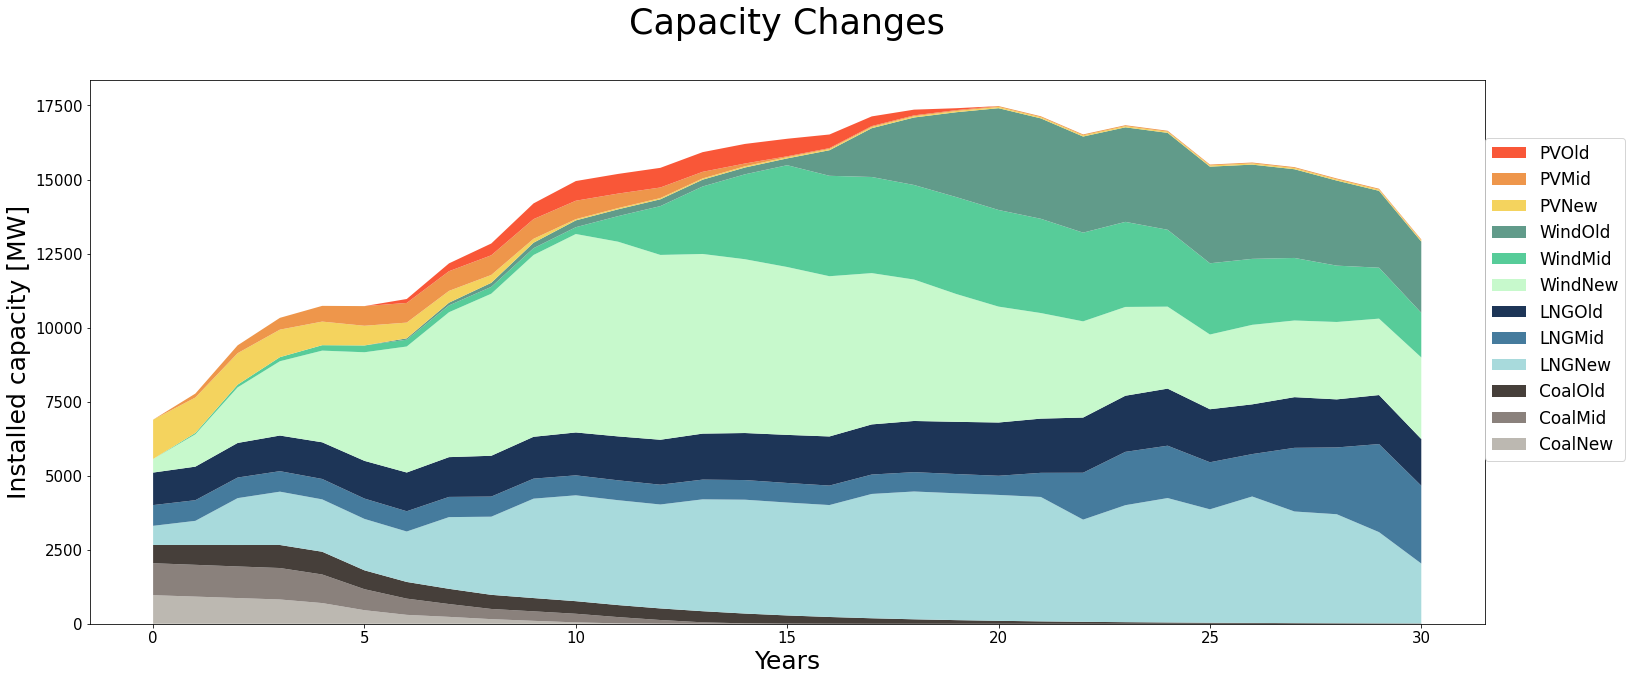

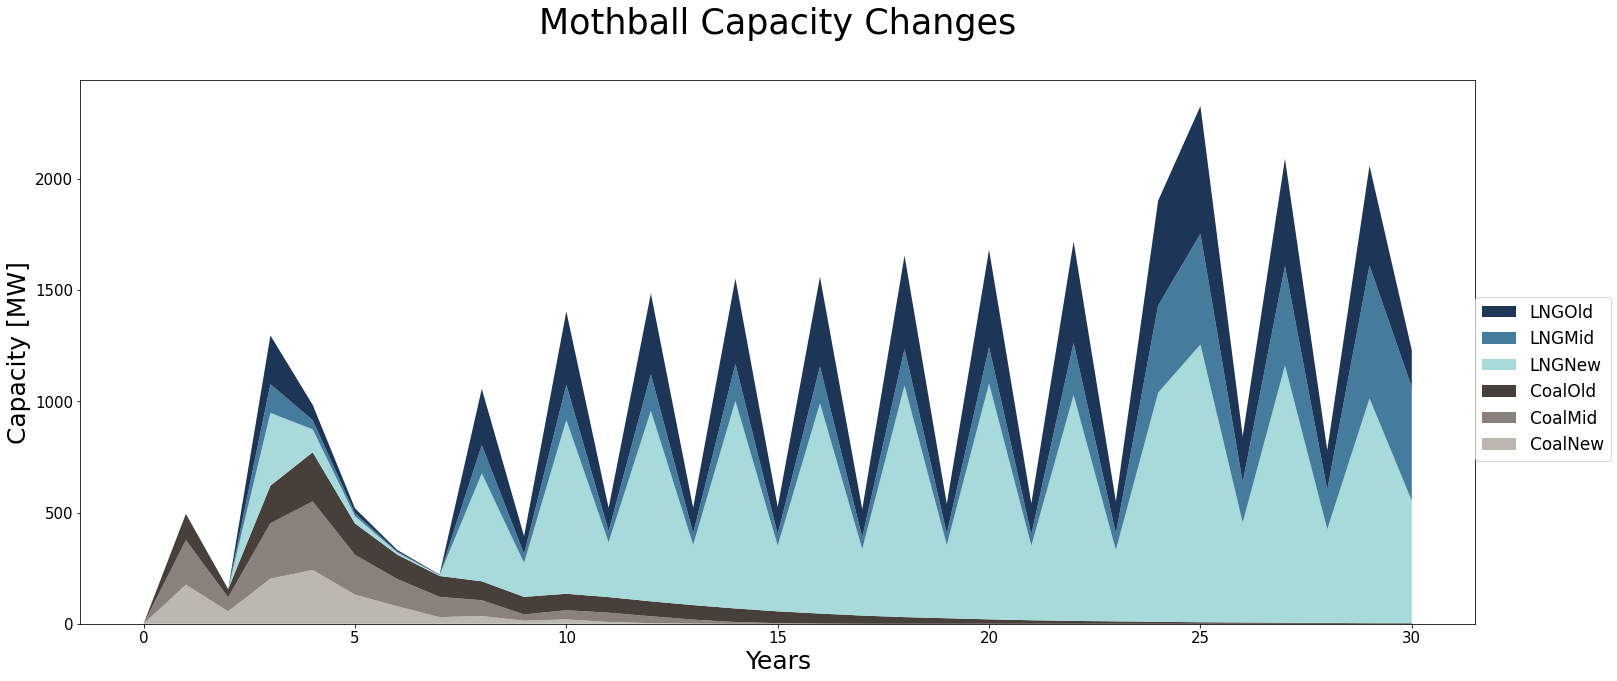

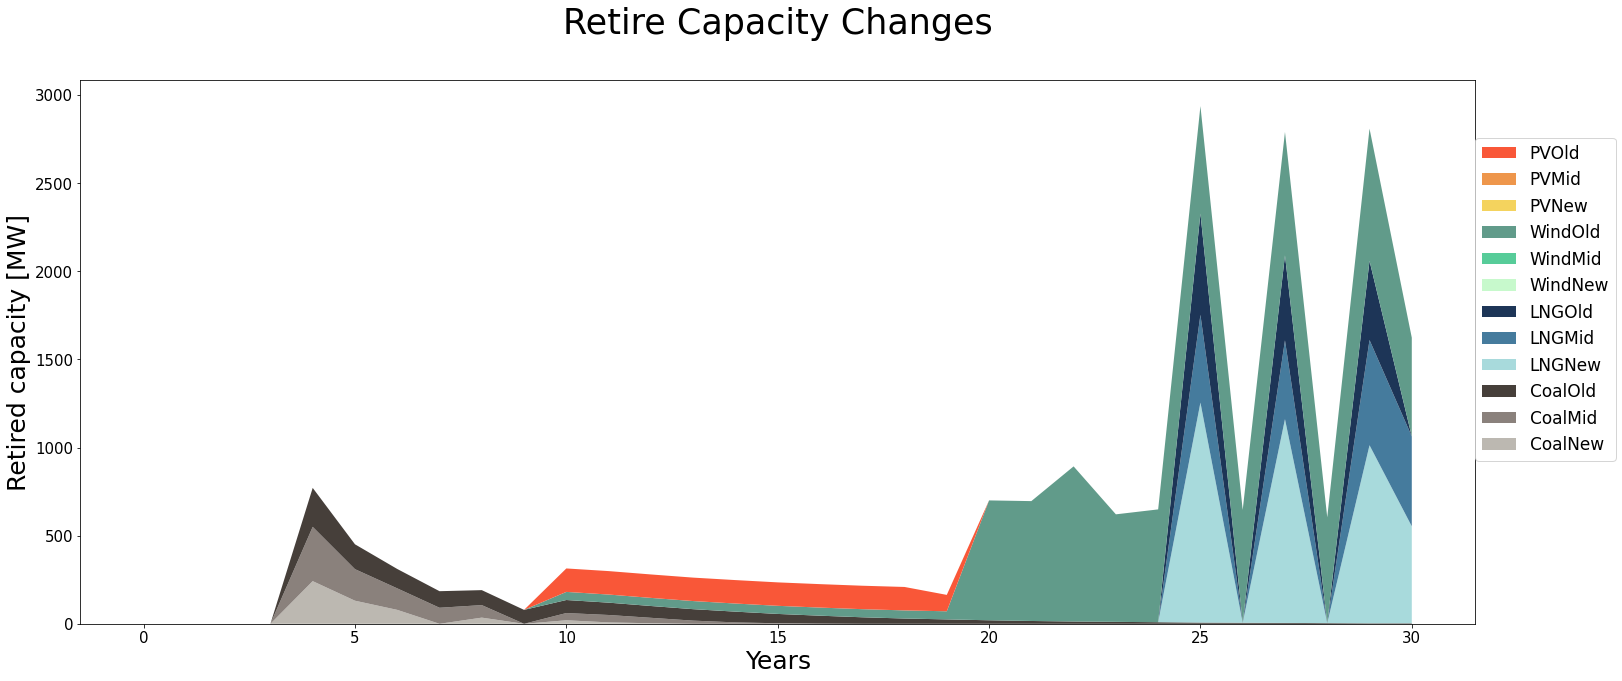

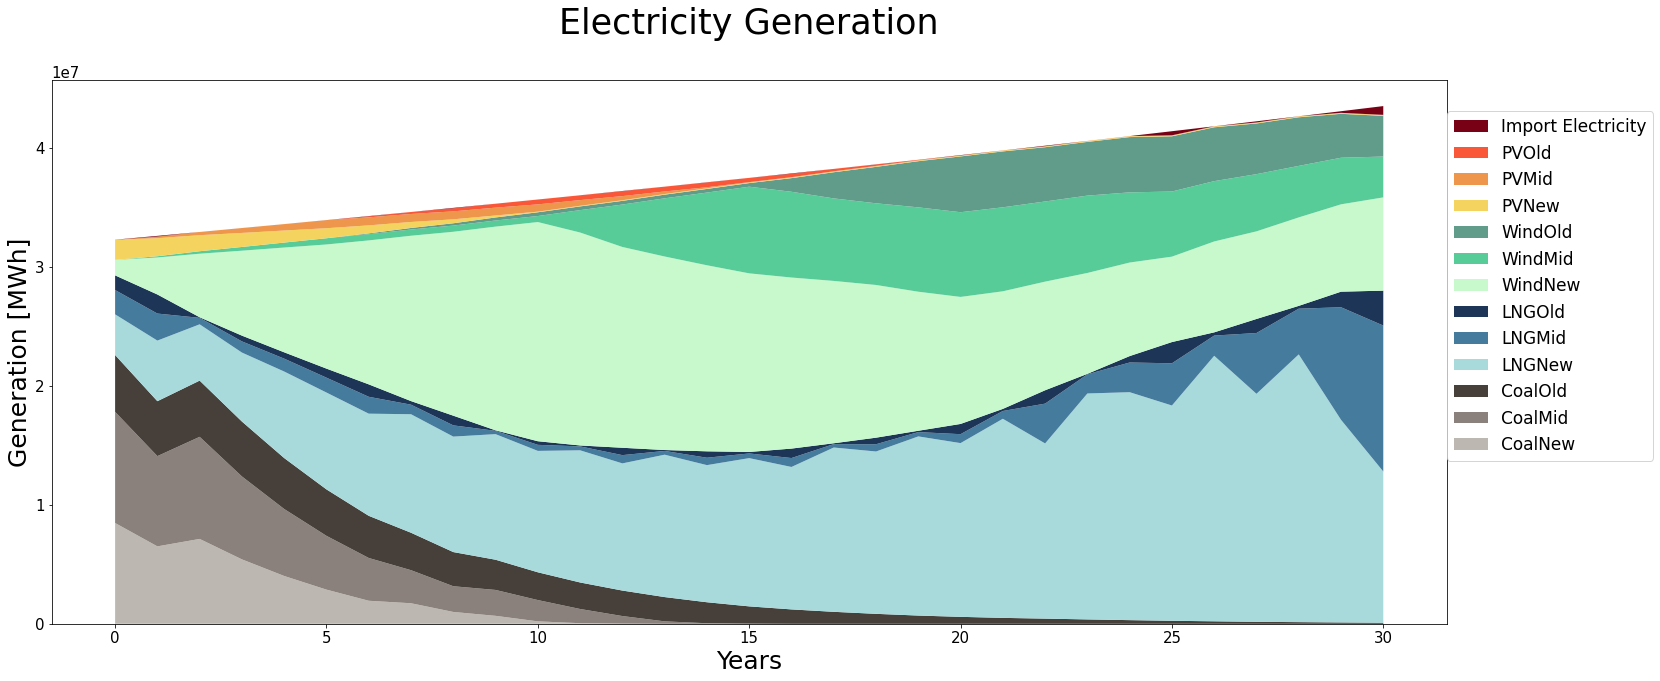

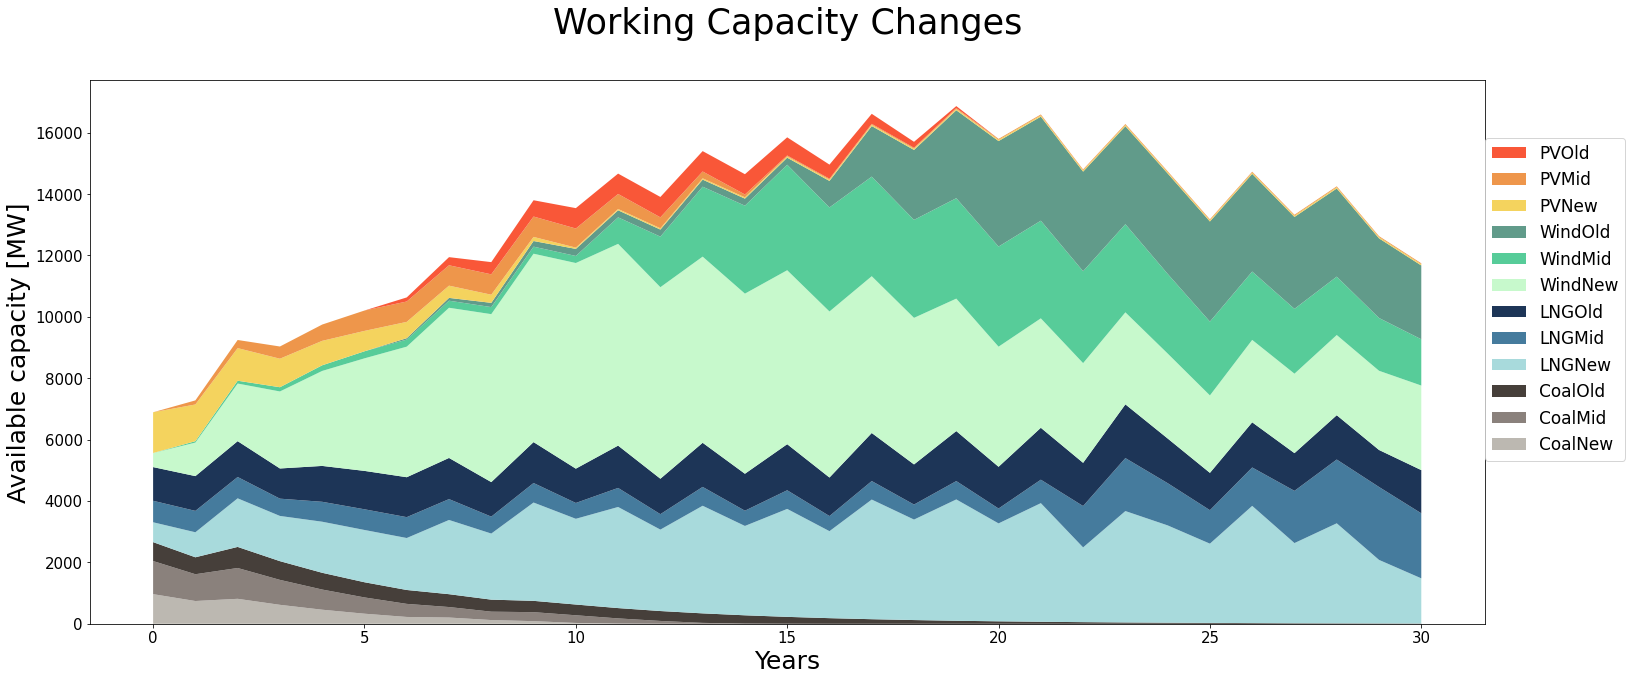

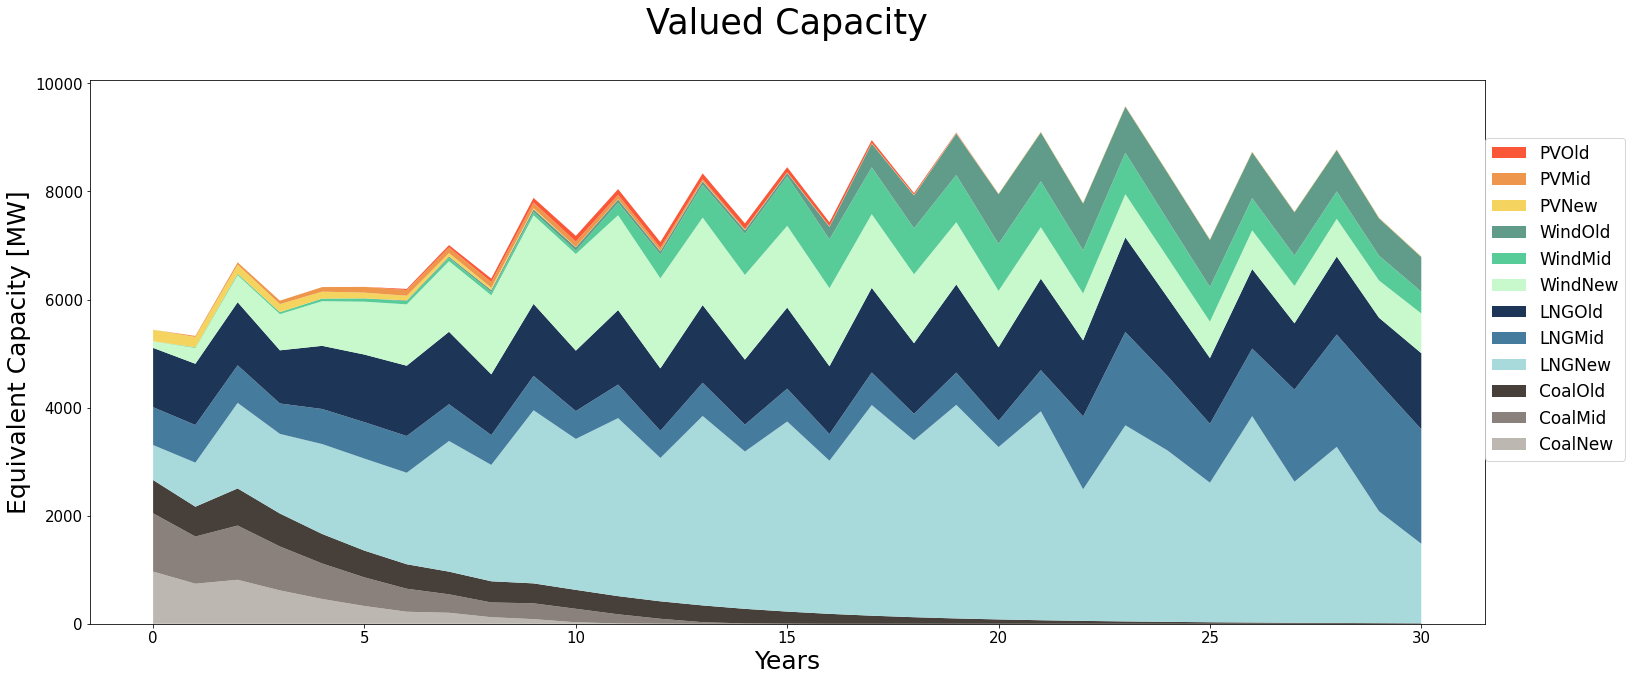

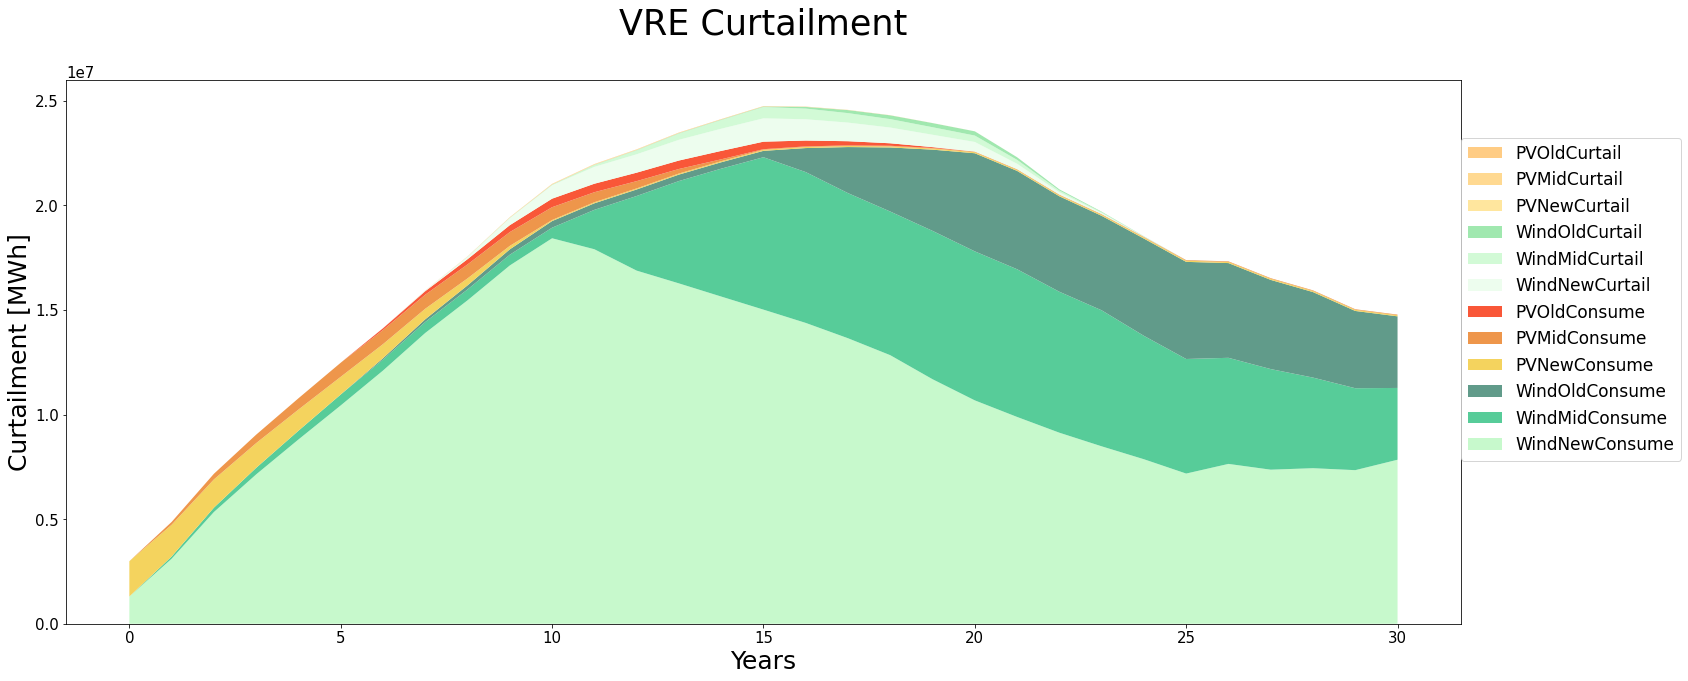

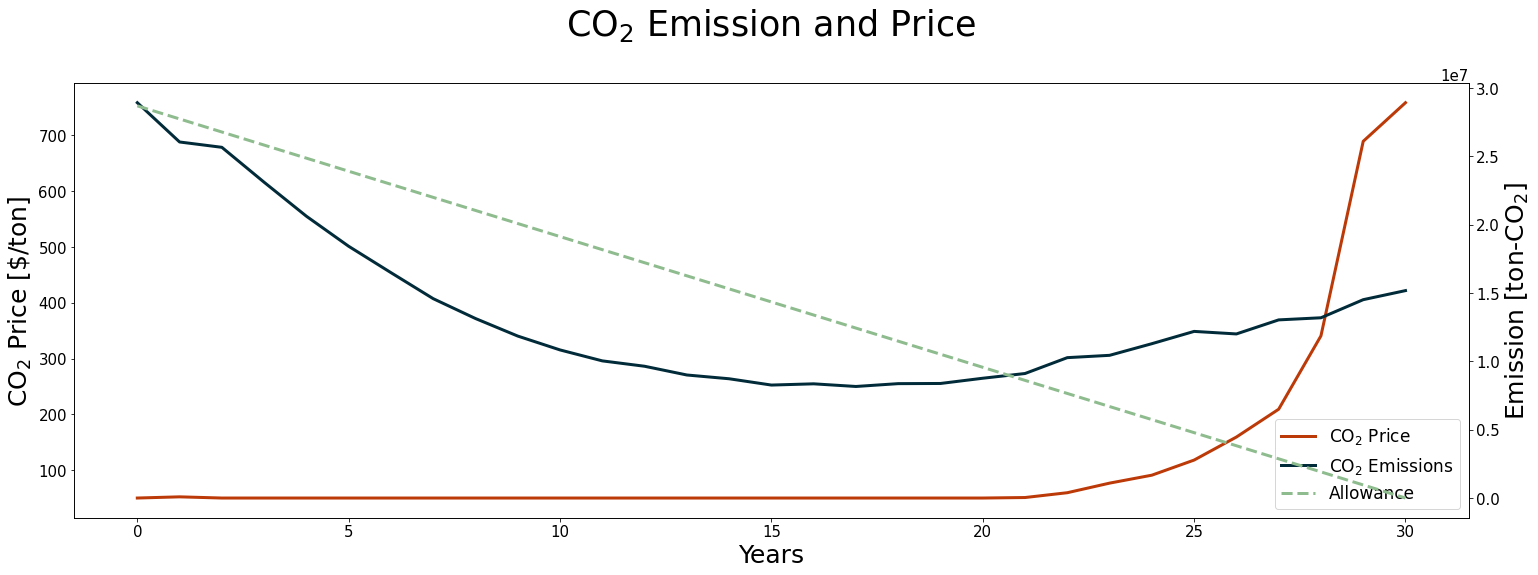

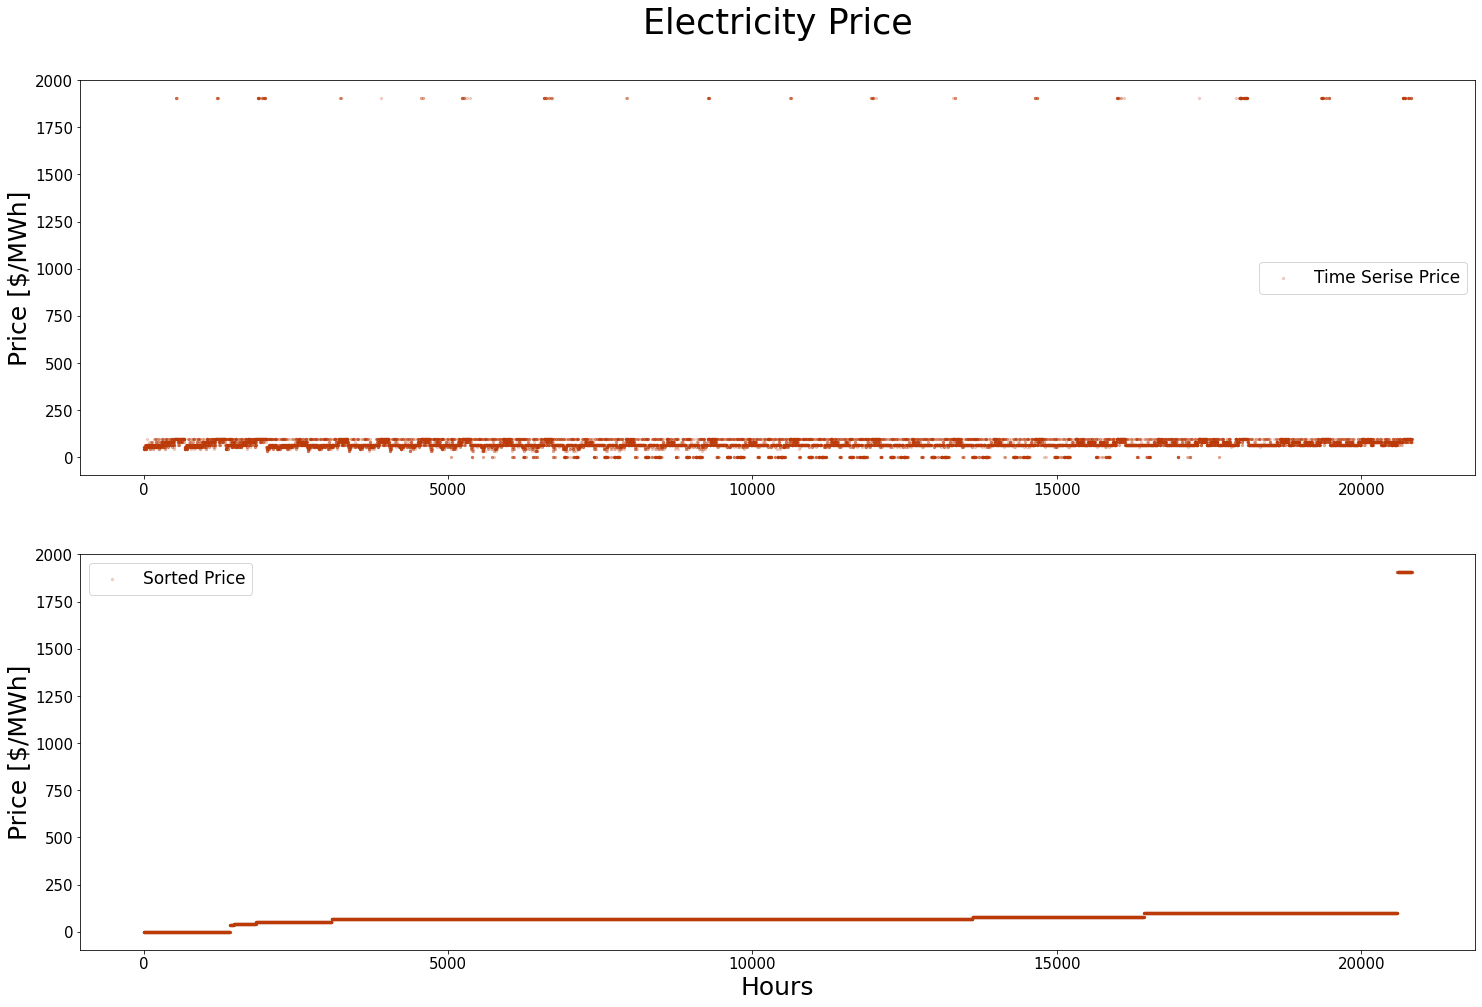

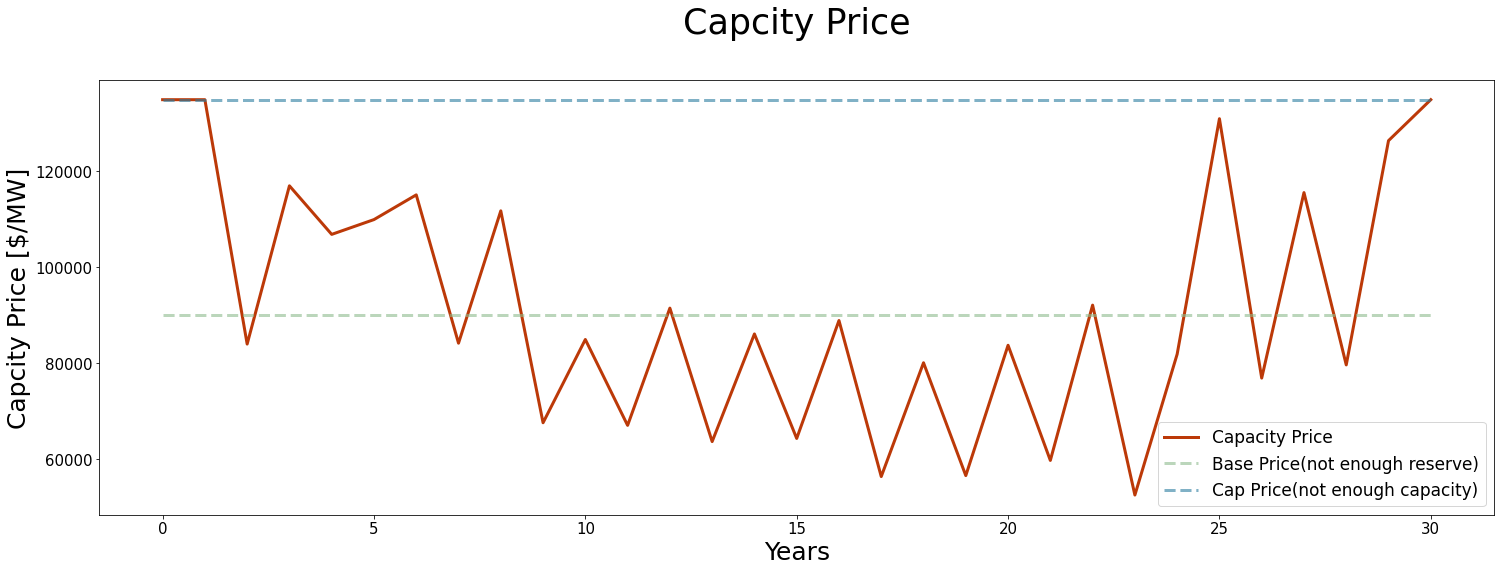

In [62]:
endTime=time.time()
print(" \n****************************************************************************************\n\
      Optimization Running Time: ",round((endTime-startTime)/60,1), 
      "mins\n****************************************************************************************\n")


Y  = np.array([t for t in range(0, years+1)])

        
fig, ax = plt.subplots(1,1,figsize=(25,10))
colorList=["bcb8b1","8a817c","463f3a","a8dadc","457b9d","1d3557","c7f9cc","57cc99","619b8a","f4d35e","ee964b","f95738","780116"]
labels=[] 
for i in Tech:
    for j in Age:
        labels.append(i+j)
         #exec ("print(\"capacityChange{}{}\")".format(i,j))
ax.stackplot(Y, capacityChangeCoalNew,
             capacityChangeCoalMid,
             capacityChangeCoalOld,
             capacityChangeLNGNew,
             capacityChangeLNGMid,
             capacityChangeLNGOld,
             capacityChangeWindNew,
             capacityChangeWindMid,
             capacityChangeWindOld,
             capacityChangePVNew,
             capacityChangePVMid,
             capacityChangePVOld,
             labels=labels, colors=colorList)
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Installed capacity [MW]')
ax.set_title('Capacity Changes\n') 


fig, ax = plt.subplots(1,1,figsize=(25,10))
labels=[]
for i in Thermal:
    for j in Age:
        labels.append(i+j)
ax.stackplot(Y, mothballChangeCoalNew,
             mothballChangeCoalMid,
             mothballChangeCoalOld,
             mothballChangeLNGNew,
             mothballChangeLNGMid,
             mothballChangeLNGOld,
             labels=labels, colors=colorList)
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Capacity [MW]')
ax.set_title('Mothball Capacity Changes\n')


fig, ax = plt.subplots(1,1,figsize=(25,10))
labels=[] 
for i in Tech:
    for j in Age:
        labels.append(i+j)
ax.stackplot(Y, retireChangeCoalNew,
             retireChangeCoalMid,
             retireChangeCoalOld,
             retireChangeLNGNew,
             retireChangeLNGMid,
             retireChangeLNGOld,
             retireChangeWindNew,
             retireChangeWindMid,
             retireChangeWindOld,
             retireChangePVNew,
             retireChangePVMid,
             retireChangePVOld,
             labels=labels, colors=colorList)
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Retired capacity [MW]')
ax.set_title('Retire Capacity Changes\n')
print("Total Retired Coal:\n","New:",sum(retireChangeCoalNew)," Mid:",sum(retireChangeCoalMid)," Old:",sum(retireChangeCoalOld))

fig, ax = plt.subplots(1,1,figsize=(25,10))
labels.append("Import Electricity")
#labels.append("Reject Supply")
ax.stackplot(Y, GenerationCoalNew,
             GenerationCoalMid,
             GenerationCoalOld,
             GenerationLNGNew,
             GenerationLNGMid,
             GenerationLNGOld,
             GenerationWindNew,
             GenerationWindMid,
             GenerationWindOld,
             GenerationPVNew,
             GenerationPVMid,
             GenerationPVOld,
             allImport,
             #allReject,
             labels=labels, colors=colorList)
#ax.plot(Y, allDemand, '--',color="#DEE2E6")
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Generation [MWh]')
ax.set_title('Electricity Generation\n')

fig, ax = plt.subplots(1,1,figsize=(25,10))
ax.stackplot(Y, workingChangeCoalNew,
             workingChangeCoalMid,
             workingChangeCoalOld,
             workingChangeLNGNew,
             workingChangeLNGMid,
             workingChangeLNGOld,
             capacityChangeWindNew,
             capacityChangeWindMid,
             capacityChangeWindOld,
             capacityChangePVNew,
             capacityChangePVMid,
             capacityChangePVOld,
             labels=labels, colors=colorList)
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Available capacity [MW]')
ax.set_title('Working Capacity Changes\n')


WindCapacityValue=0.266963886
PVCapacityValue=0.159827451
for i in vreSD:
    for j in ageSD:

        exec ("valued{}{}=[i*{}CapacityValue for i in capacityChange{}{}]".format(i,j,i,i,j))

fig, ax = plt.subplots(1,1,figsize=(25,10))
ax.stackplot(Y, workingChangeCoalNew,
             workingChangeCoalMid,
             workingChangeCoalOld,
             workingChangeLNGNew,
             workingChangeLNGMid,
             workingChangeLNGOld,
             valuedWindNew,
             valuedWindMid,
             valuedWindOld,
             valuedPVNew,
             valuedPVMid,
             valuedPVOld,
             labels=labels, colors=colorList)
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Equivalent Capacity [MW]')
ax.set_title('Valued Capacity\n')



fig, ax = plt.subplots(1,1,figsize=(25,10))
labels=[]
for i in VRE:
    for j in Age:
        labels.append(i+j+'Consume')
for i in VRE:
    for j in Age:
        labels.append(i+j+'Curtail')
        
ax.stackplot(Y, 
            GenerationWindNew,
            GenerationWindMid,
            GenerationWindOld,
            GenerationPVNew,
            GenerationPVMid,
            GenerationPVOld,
            CurtailWindNew,
            CurtailWindMid,
            CurtailWindOld,
            CurtailPVNew,
            CurtailPVMid,
            CurtailPVOld,
            labels=labels, colors=colorList[6:12]+["edfdee","d2fad6","a0e8af","ffe69e","ffd991","ffcc84"])
a,b=ax.get_legend_handles_labels()
ax.legend(a[::-1],b[::-1],loc=(1,0.3))
#颠倒默认图例顺序使之与堆叠匹配
ax.set_xlabel('Years')
ax.set_ylabel('Curtailment [MWh]')
ax.set_title('VRE Curtailment\n') 

fig, ax = plt.subplots(1,1,figsize=(25,8))
l1=ax.plot(Y, allCO2Price,c="#bc3908",label="CO$_2$ Price")
ax.set_ylabel("CO$_2$ Price [\$/ton]")
ax2=ax.twinx()
l2=ax2.plot(Y, allCO2,label="CO$_2$ Emissions",c="#022b3a")
l3=ax2.plot(Y, allowance, c="darkseagreen",linestyle="--",label="Allowance")
ax2.set_ylabel("Emission [ton-CO$_2$]")
ax.set_xlabel('Years')
a1,b1=ax.get_legend_handles_labels()
a2,b2=ax2.get_legend_handles_labels()
ax.legend(a1+a2,b1+b2,loc="lower right")
ax.set_title('CO$_2$ Emission and Price\n')
print("Life Emission:",round(sum(allCO2),0))


y=np.array(allElecPrice).flatten()
x=np.array([t for t in range(0, len(y))])
fig, ax = plt.subplots(2,1,figsize=(25,16))
ax[0].scatter(x, y,s=5,alpha=0.2,label="Time Serise Price",c="#bc3908")
ax[1].scatter(x, np.sort(y),s=5,alpha=0.2,label="Sorted Price",c="#bc3908")
ax[1].set_xlabel('Hours')
ax[0].set_ylabel('Price [$/MWh]')
ax[1].set_ylabel('Price [$/MWh]')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Electricity Price\n') 

fig, ax = plt.subplots(1,1,figsize=(25,8))
ax.plot(Y,allCapacityPrice,label="Capacity Price",c="#bc3908")
ax.plot(Y, [capacityBasePrice for i in Y],'--',alpha=0.6,label="Base Price(not enough reserve)",c="darkseagreen")
ax.plot(Y, [capacityBasePrice*1.5 for i in Y],'--',alpha=0.6,label="Cap Price(not enough capacity)",c="#2c7da0")
ax.set_ylabel("Capcity Price [$/MW]")
ax.set_xlabel('Years')
ax.legend(loc="lower right")
ax.set_title('Capcity Price\n')


In [63]:

print(GenerationCoalNew[0]+GenerationCoalMid[0]+GenerationCoalOld[0])
print(GenerationLNGNew[0]+GenerationLNGMid[0]+GenerationLNGOld[0])
print(GenerationWindNew[0]+GenerationWindMid[0]+GenerationWindOld[0])
print(GenerationPVNew[0]+GenerationPVMid[0]+GenerationPVOld[0])
print("***************")
print(GenerationCoalNew[30]+GenerationCoalMid[30]+GenerationCoalOld[30])
print(GenerationLNGNew[30]+GenerationLNGMid[30]+GenerationLNGOld[30])
print(GenerationWindNew[30]+GenerationWindMid[30]+GenerationWindOld[30])
print(GenerationPVNew[30]+GenerationPVMid[30]+GenerationPVOld[30])
print("***************")
print((GenerationCoalNew[30]+GenerationCoalMid[30]+GenerationCoalOld[30])/(GenerationCoalNew[0]+GenerationCoalMid[0]+GenerationCoalOld[0]))
print((GenerationLNGNew[30]+GenerationLNGMid[30]+GenerationLNGOld[30])/(GenerationLNGNew[0]+GenerationLNGMid[0]+GenerationLNGOld[0]))
print((GenerationWindNew[30]+GenerationWindMid[30]+GenerationWindOld[30])/(GenerationWindNew[0]+GenerationWindMid[0]+GenerationWindOld[0]))


22599802.5
6695242.600000001
1306544.6
1685423.3
***************
87730.4
27922965.9
14696776.899999999
82810.5
***************
0.0038819100299659695
4.170568203159658
11.248584166204504
